In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import timeit
import threading

In [34]:
# PDF Example
d = stats.norm(0, 1)

x = np.arange(-5, 5.01, 0.01)
df = pd.DataFrame({'x': x})
df['pdf'] = d.pdf(x)

print(df.head())

      x       pdf
0 -5.00  0.000001
1 -4.99  0.000002
2 -4.98  0.000002
3 -4.97  0.000002
4 -4.96  0.000002


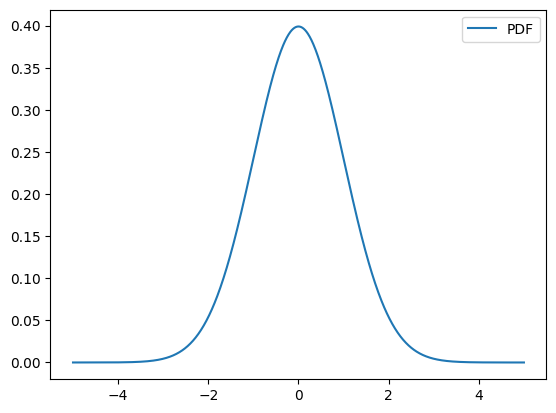

In [35]:
plt.figure()
plt.plot(df['x'], df['pdf'], label='PDF')
plt.legend()
# plt.savefig('pdf.png')

In [36]:
# CDF
df['cdf'] = d.cdf(x)

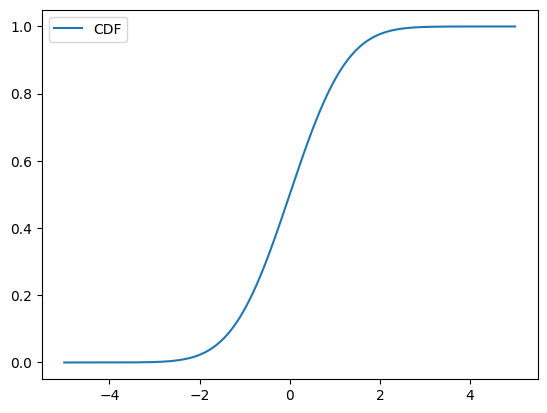

In [37]:
plt.figure()
plt.plot(df['x'], df['cdf'], label='CDF')
plt.legend()
plt.show()
# plt.savefig('cdf.png')

In [38]:
# Quick and dirty integration of the PDF
n = 501
approxCDF = 0.0
for i in range(0,n):
    approxCDF += df['pdf'][i] * 0.01

print(f"CDF actual {df['cdf'].iloc[n-1]} vs calculated {approxCDF} for F_x({df['x'].iloc[n-1]})")

CDF actual 0.4999999999999575 vs calculated 0.5019944321220569 for F_x(-1.0658141036401503e-13)


In [39]:
# Calculation of moments

# Simulate based on the defined Distribution above, N(0,1)
# Expect  μ = 0, 
#       σ^2 = 1,
#      skew = 0,
#      kurt = 3 (excess = 0)

n = 1000
sim = d.rvs(n)

def first4Moments(sample):
    n = len(sample)
    
    # mean
    μ_hat = np.sum(sample) / n
    
    # remove the mean from the sample
    sim_corrected = sample - μ_hat
    cm2 = np.sum(sim_corrected**2) / n
    
    # variance
    σ2_hat = np.sum(sim_corrected**2) / (n-1)
    
    # skew
    skew_hat = np.sum(sim_corrected**3) / n / np.sqrt(cm2**3)
    
    # kurtosis
    kurt_hat = np.sum(sim_corrected**4) / n / (cm2**2)
    
    excessKurt_hat = kurt_hat - 3
    
    return μ_hat, σ2_hat, skew_hat, excessKurt_hat

m, s2, sk, k = first4Moments(sim)

print(f"Mean {m} ({np.mean(sim)})")
print(f"Variance {s2} ({np.var(sim, ddof=1)})")
print(f"Skew {sk} ({stats.skew(sim)})")
print(f"Kurtosis {k} ({stats.kurtosis(sim, fisher=True)})")

print(f"mean diff = {m - np.mean(sim)}")
print(f"Variance diff = {s2 - np.var(sim, ddof=1)}")
print(f"Skewness diff = {sk - stats.skew(sim)}")
print(f"Kurtosis diff = {k - stats.kurtosis(sim, fisher=True)}")


Mean -0.009752516437624056 (-0.009752516437624056)
Variance 0.9774022492652766 (0.9774022492652766)
Skew 0.01840799131561671 (0.01840799131561674)
Kurtosis -0.14113150044888734 (-0.14113150044888734)
mean diff = 0.0
Variance diff = 0.0
Skewness diff = -3.122502256758253e-17
Kurtosis diff = 0.0


In [40]:
# Study the limiting expected values from the estimators
sample_size = 1000
samples = 100

means = np.zeros(samples)
vars = np.zeros(samples)
skews = np.zeros(samples)
kurts = np.zeros(samples)

def calculate_moments(i):
    means[i], vars[i], skews[i], kurts[i] = first4Moments(d.rvs(sample_size))

threads = []
for i in range(samples):
    thread = threading.Thread(target=calculate_moments, args=(i,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

print(f"Mean versus Expected {np.mean(means) - d.mean()}")
print(f"Variance versus Expected {np.mean(vars) - d.var()}")
print(f"Skewness versus Expected {np.mean(skews) - d.stats(moments='s')}")
print(f"Kurtosis versus Expected {np.mean(kurts) - d.stats(moments='k')}")

Mean versus Expected 0.004040939757373743
Variance versus Expected -0.006612542133796029
Skewness versus Expected 0.004590284058040989
Kurtosis versus Expected 0.006669560014761591


In [41]:
# Test the kurtosis function for bias in small sample sizes
sample_size = 100
samples = 100
kurts = np.zeros(samples)

def calculate_kurtosis(i):
    kurts[i] = stats.kurtosis(d.rvs(sample_size), fisher=False)

threads = []
for i in range(samples):
    thread = threading.Thread(target=calculate_kurtosis, args=(i,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

# Summary statistics
print(pd.Series(kurts).describe())

# Using the t-test
t_stat, p_value = stats.ttest_1samp(kurts, 0.0)
print(f"p-value - {p_value}")


count    100.000000
mean       2.915672
std        0.422251
min        2.206807
25%        2.610137
50%        2.867792
75%        3.184521
max        4.241312
dtype: float64
p-value - 1.4858111481377976e-85
